# Importações

In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Leitura dataset e pré-processamento

In [791]:
global dataset
global dataset_original

def load_dataset():
    global dataset
    global dataset_original
    
    dataset = pd.read_csv('dataset-unificado.csv', sep=';')
    dataset_original = dataset
    
def under_sampling():
    global dataset
    
    #rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:299, 2:900, 3:826, 4:458, 5:233})
    rus = RandomUnderSampler(random_state=0, sampling_strategy={0:0, 1:16, 2:1224, 3:826, 4:458, 5:233})
    X_res, y_res = rus.fit_resample(
            pd.DataFrame(dataset.index.array)[0].values.reshape(-1,1), 
            dataset['Cyclomatic'].values
    )

    dataset = dataset.iloc[X_res.reshape(1,-1)[0]]
    
def remove_last_column():
    global dataset
    
    dataset = dataset.iloc[:,:-1]
    
def remove_nan():
    global dataset
    
    dataset = dataset.dropna()
    
def fix_coverage_metrics():
    global dataset
    
    dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
    dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))
    
def remove_coverage_metrics_with_zero():
    global dataset
    
    dataset = dataset[dataset['EdgeCoverage'] > 0]
    dataset = dataset[dataset['PrimePathCoverage'] > 0]
    
def select_metrics(metrics):
    global dataset
    
    dataset = dataset[metrics]
    
def print_dataset_info():
    global dataset
    
    print('Dataset size: ', dataset.shape[0])
    print('Dataset original size: ', dataset_original.shape[0])
    print('Média complexidade dataset: ', dataset_original['Cyclomatic'].mean())
    print('Média complexidade dataset balanceado: ', dataset['Cyclomatic'].mean())
    plt.title("Complexidade do dataset após pré-processamento")
    sns.histplot(dataset['Cyclomatic'])

In [792]:
load_dataset()
under_sampling()
remove_last_column()
remove_nan()
fix_coverage_metrics()
remove_coverage_metrics_with_zero()
select_metrics([
    # Método testado
    'Name','CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage','PrimePathCoverage',
    
    # Método de teste
    'Name.1','CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1',
    'CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1',
    'Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1',
])

# Características do dataset

Dataset size:  3000
Dataset original size:  5342
Média complexidade dataset:  3.3569824035941593
Média complexidade dataset balanceado:  4.600333333333333


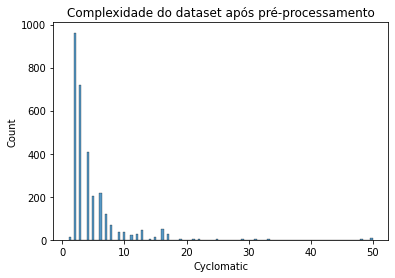

In [787]:
print_dataset_info()

<AxesSubplot:title={'center':'Contribuição de cada projeto no dataset'}, xlabel='count', ylabel='Project'>

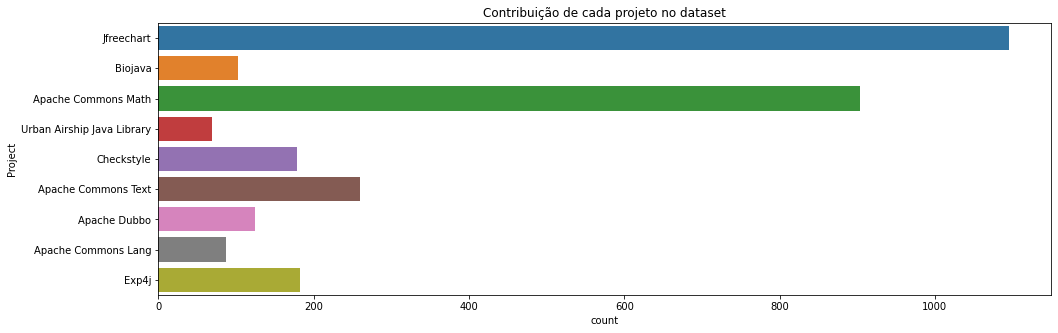

In [788]:
def signature_to_project(signature):
    project = ''
    
    if 'com.puppycrawl.tools.checkstyle' in signature:
        project = 'Checkstyle'
    elif 'exp4j' in signature:
        project = 'Exp4j'
    elif 'biojava' in signature:
        project = 'Biojava'
    elif 'org.jfree' in signature:
        project = 'Jfreechart'
    elif 'com.urbanairship' in signature:
        project = 'Urban Airship Java Library'
    elif 'org.apache.commons.text' in signature:
        project = 'Apache Commons Text'
    elif 'dubbo' in signature:
        project = 'Apache Dubbo'
    elif 'org.apache.commons.lang3' in signature:
        project = 'Apache Commons Lang'
    elif 'math3' in signature:
        project = 'Apache Commons Math'
        
    return project

d2 = dataset
d2['Project'] = dataset['Name'].apply(signature_to_project)
plt.figure(figsize=(16,5))
plt.title("Contribuição de cada projeto no dataset")

contrib_projetos = d2.groupby('Project')
contrib_projetos = contrib_projetos.count()

sns.countplot(y='Project', data=d2, orient='h')

<AxesSubplot:xlabel='count', ylabel='Project'>

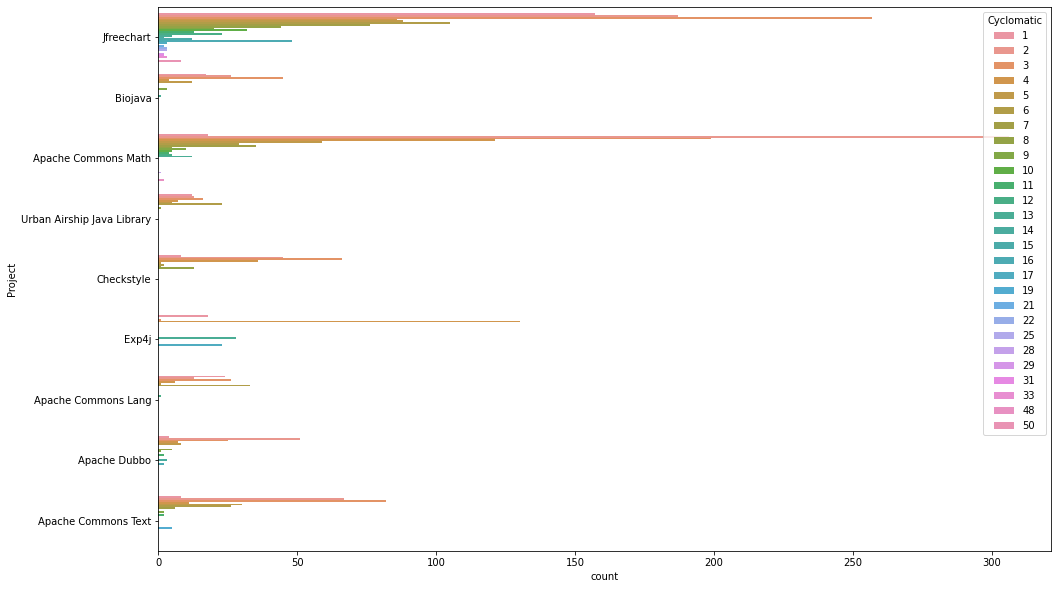

In [749]:
plt.figure(figsize=(16,10))
sns.countplot(y='Project', data=d2, orient='h', hue='Cyclomatic')

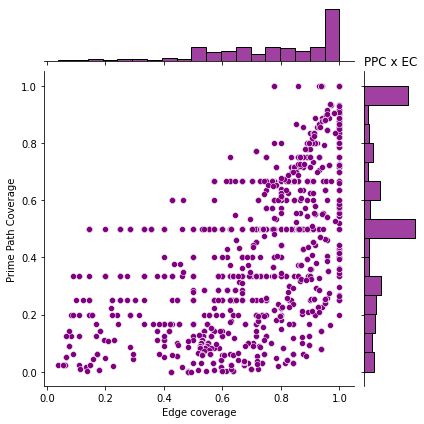

In [750]:
ax = sns.jointplot(x='EdgeCoverage', y='PrimePathCoverage', data=dataset, kind='scatter', color='purple')
ax.set_axis_labels('Edge coverage', 'Prime Path Coverage')
plt.title("PPC x EC")
plt.show(ax)

<AxesSubplot:title={'center':'Correlação das métricas'}>

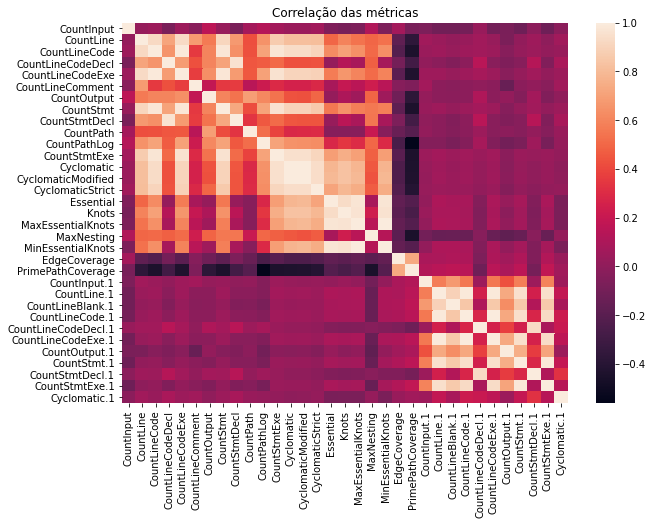

In [673]:
plt.figure(figsize=(10,7))
plt.title("Correlação das métricas")
sns.heatmap(dataset.corr())

In [674]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1995 to 2424
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 3000 non-null   object 
 1   CountInput           3000 non-null   int64  
 2   CountLine            3000 non-null   int64  
 3   CountLineCode        3000 non-null   int64  
 4   CountLineCodeDecl    3000 non-null   int64  
 5   CountLineCodeExe     3000 non-null   int64  
 6   CountLineComment     3000 non-null   int64  
 7   CountOutput          3000 non-null   int64  
 8   CountStmt            3000 non-null   int64  
 9   CountStmtDecl        3000 non-null   int64  
 10  CountPath            3000 non-null   int64  
 11  CountPathLog         3000 non-null   int64  
 12  CountStmtExe         3000 non-null   int64  
 13  Cyclomatic           3000 non-null   int64  
 14  CyclomaticModified   3000 non-null   int64  
 15  CyclomaticStrict     3000 non-null 

In [675]:
dataset.describe()

,CountInput,CountLine,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountStmt,CountStmtDecl,CountPath,...,CountLine.1,CountLineBlank.1,CountLineCode.1,CountLineCodeDecl.1,CountLineCodeExe.1,CountOutput.1,CountStmt.1,CountStmtDecl.1,CountStmtExe.1,Cyclomatic.1
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000
mean,24.137667,28.850667,18.114667,3.391667,12.415333,9.738000,6.039333,12.694333,3.371667,82.302333,...,24.090667,2.632000,18.889667,4.636000,16.073000,8.250333,15.091000,4.314000,10.77700,1.436667
std,41.207686,24.805647,18.068619,4.100960,14.044498,9.222746,5.423245,12.265332,3.910920,686.826303,...,31.442572,5.931299,22.691198,3.375792,22.391445,6.413115,18.975882,3.138793,18.33974,1.249470
min,1.000000,4.000000,4.000000,1.000000,2.000000,0.000000,1.000000,3.000000,1.000000,1.000000,...,3.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.00000,1.000000
25%,6.000000,16.000000,9.000000,1.000000,5.000000,6.000000,3.000000,6.000000,1.000000,2.000000,...,10.000000,0.000000,8.000000,3.000000,6.000000,5.000000,6.000000,2.000000,3.00000,1.000000
50%,10.000000,22.000000,13.000000,2.000000,9.000000,8.000000,5.000000,9.000000,2.000000,3.000000,...,16.000000,1.000000,13.000000,4.000000,10.000000,7.000000,10.000000,3.000000,6.00000,1.000000
75%,22.000000,32.000000,20.000000,3.000000,14.000000,11.000000,8.000000,15.000000,3.000000,6.000000,...,27.000000,3.000000,20.000000,6.000000,17.000000,10.000000,17.000000,5.000000,12.00000,1.000000
max,201.000000,431.000000,225.000000,51.000000,194.000000,156.000000,58.000000,144.000000,49.000000,6912.000000,...,395.000000,97.000000,273.000000,32.000000,270.000000,70.000000,230.000000,32.000000,226.00000,20.000000


# Funções uteis

In [793]:
k = 10
metricas_erro = [
    'r2', 'max_error', 'neg_mean_absolute_error',
    'neg_mean_squared_error', 'neg_root_mean_squared_error',
    'neg_mean_squared_log_error', 'neg_median_absolute_error'
]
previsores = [
    # Método testado
    'CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','EdgeCoverage',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1',
    'CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1',
    'Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1',
]

In [753]:
def escalonador(dados):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador, d = dataset, k=11, apenas_escalonamento=False):
    ppc = d['PrimePathCoverage'].values
    previsores_content = d[previsores].values

    if not apenas_escalonamento:
        resultados = cross_validate(
                classificador, 
                previsores_content, 
                ppc, 
                cv=k, 
                scoring=metricas_erro, 
                return_estimator=True
        )
        
        print('-----< SEM ESCALONAMENTO >-----')
        print('Mean Abs Error: ', abs(resultados['test_neg_mean_absolute_error'].mean()))
        print('Mean Sqr Error: ', abs(resultados['test_neg_mean_squared_error'].mean()))
        print('Mean Sqr Log Error: ', abs(resultados['test_neg_mean_squared_log_error'].mean()))
        print('Mean Median Error: ', abs(resultados['test_neg_median_absolute_error'].mean()))
        print('R2 Score: ', abs(resultados['test_r2'].mean()))
        
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro, 
            return_estimator=True
    )
    
    print('-----< COM ESCALONAMENTO >-----')
    print('Mean Abs Error: ', abs(resultados_escalonados['test_neg_mean_absolute_error'].mean()))
    print('Mean Sqr Error: ', abs(resultados_escalonados['test_neg_mean_squared_error'].mean()))
    print('Mean Sqr Log Error: ', abs(resultados_escalonados['test_neg_mean_squared_log_error'].mean()))
    print('Mean Median Error: ', abs(resultados_escalonados['test_neg_median_absolute_error'].mean()))
    print('R2 Score: ', abs(resultados_escalonados['test_r2'].mean()))

In [794]:
def feature_importance(classificador, d = dataset, prev = previsores):
    ppc = d['PrimePathCoverage'].values
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    previsores_content = d[prev].values
    resultados = cross_validate(
            classificador, 
            previsores_content, 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    resultados_escalonados = cross_validate(
            classificador, 
            escalonador(previsores_content), 
            ppc, 
            cv=k, 
            scoring=metricas_erro,
            return_estimator=True
    )
    
    print('-----< SEM ESCALONAMENTO >-----')
    #print(resultados)
    for idx,estimator in enumerate(resultados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances
 
    #print(importance_dataset) 
    importance_dataset['mean'] = importance_dataset['importance'] / k
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()
    
    importance_dataset = pd.DataFrame(
            [0]*len(prev),
            index=prev,
            columns=['importance']
    )
    print('\n')
    
    print('-----< COM ESCALONAMENTO >-----')
    for idx,estimator in enumerate(resultados_escalonados['estimator']):
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                           index=prev,
                                           columns=['importance'])
        importance_dataset += feature_importances

    importance_dataset['mean'] = importance_dataset['importance'] / k
    print(importance_dataset['mean'].sort_values(ascending=False))
    plt.figure(figsize=(10,9))
    plt.title("Feature importance - Random forest - K = 10 - Mean")
    plt.barh(prev, importance_dataset['mean'].values)
    plt.show()

# Experimentos

## Linear Regression

### Com EC

In [389]:
for previsor in previsores:
    print('PREVISOR ', previsor)
    evaluate([
        previsor
    ], LinearRegression(fit_intercept=False), dataset)
    print('\n')

PREVISOR  CountInput
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.5113811723121303
Mean Sqr Error:  0.3443939420612599
Mean Sqr Log Error:  0.16933608361345154
Mean Median Error:  0.4712196897190062
R2 Score:  4.868084925774024
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.5146063127227829
Mean Sqr Error:  0.3474823595691958
Mean Sqr Log Error:  0.17263893146338755
Mean Median Error:  0.474078699886199
R2 Score:  4.90730113161497


PREVISOR  CountLine
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.4787151759703379
Mean Sqr Error:  0.4151159843941102
Mean Sqr Log Error:  0.14761571730346787
Mean Median Error:  0.4275589682082019
R2 Score:  5.273851622709836
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.508558050839172
Mean Sqr Error:  0.46148135401431695
Mean Sqr Log Error:  0.1656806629765257
Mean Median Error:  0.4524008959433639
R2 Score:  5.984368240953999


PREVISOR  CountLineCode
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.5361465396780868
Mean Sqr Error

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.39901951867883695
Mean Sqr Error:  0.26391346556805145
Mean Sqr Log Error:  0.10836491248962475
Mean Median Error:  0.3643533693203723
R2 Score:  3.417083712556496
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.422558539114257
Mean Sqr Error:  0.2864299925582319
Mean Sqr Log Error:  0.1238792899540723
Mean Median Error:  0.3890979040502861
R2 Score:  3.8092225409191567


PREVISOR  CountLineBlank.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.4900558501633002
Mean Sqr Error:  0.34189914555295303
Mean Sqr Log Error:  0.16799651558590345
Mean Median Error:  0.45652914144510603
R2 Score:  4.787292234575727
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.4900558501633002
Mean Sqr Error:  0.3418991455529529
Mean Sqr Log Error:  0.16799651558590345
Mean Median Error:  0.45652914144510603
R2 Score:  4.787292234575726


PREVISOR  CountLineCode.1
-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.38749383818524913
Mean Sqr Error:  0

In [390]:
evaluate([
    'EdgeCoverage'
], LinearRegression(fit_intercept=False), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.18701163847417382
Mean Sqr Error:  0.04978423480931995
Mean Sqr Log Error:  0.022762171207405393
Mean Median Error:  0.18675131092771824
R2 Score:  0.2052283031015255
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.1856371278999595
Mean Sqr Error:  0.04894545894387141
Mean Sqr Log Error:  0.022469251347105174
Mean Median Error:  0.186554019611708
R2 Score:  0.2178326581766573


In [391]:
evaluate([
    'MaxNesting'
], LinearRegression(fit_intercept=False), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.3856041093161331
Mean Sqr Error:  0.24551971260558794
Mean Sqr Log Error:  0.10449696246431558
Mean Median Error:  0.30584146730206546
R2 Score:  2.9632427467693314
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.3856041093161332
Mean Sqr Error:  0.24551971260558803
Mean Sqr Log Error:  0.1044969624643156
Mean Median Error:  0.3058414673020656
R2 Score:  2.9632427467693323


### Sem EC

## SVR

### Com EC

In [395]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], SVR(epsilon=0.3), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.15557701421484435
Mean Sqr Error:  0.033340735178907295
Mean Sqr Log Error:  0.015158177396452411
Mean Median Error:  0.14916278211598355
R2 Score:  0.4671170680235315


In [396]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], SVR(epsilon=0.3), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.15312250527793178
Mean Sqr Error:  0.03281699966200945
Mean Sqr Log Error:  0.014481518650789827
Mean Median Error:  0.14763166798241195
R2 Score:  0.47911984064973334


In [398]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], SVR(epsilon=0.3), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.22216451452737507
Mean Sqr Error:  0.06683938092215654
Mean Sqr Log Error:  0.029111327234470595
Mean Median Error:  0.20609353798182728
R2 Score:  0.06947130686218693


In [399]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], SVR(epsilon=0.2), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.20235347856804428
Mean Sqr Error:  0.0597414543678255
Mean Sqr Log Error:  0.025561697631554737
Mean Median Error:  0.18428156190551342
R2 Score:  0.04336074968356554


In [400]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], SVR(epsilon=0.4), dataset, apenas_escalonamento=True)

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.18126947138189653
Mean Sqr Error:  0.04693163283907308
Mean Sqr Log Error:  0.019932368497859367
Mean Median Error:  0.16115635935416703
R2 Score:  0.2447810677691809


### Sem EC

## Neural network

### Com EC

In [345]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\skl

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [346]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified',
    'CountOutput',
    'Essential',
    'CountLine',
    'EdgeCoverage'
], MLPRegressor(
        hidden_layer_sizes=(122,), 
        activation='tanh', 
        learning_rate='invscaling', 
        alpha=0.1,
        random_state=0
), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [347]:
evaluate([
    'CountInput','CountLine','CountOutput','CountPath','CountStmt','CountStmtDecl','Knots',
    'MaxNesting','MinEssentialKnots',
    
    'CountInput.1','CountLine.1','CountLineCodeDecl.1','CountOutput.1','CountStmtDecl.1','CountStmtExe.1'
], MLPRegressor(), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [348]:
evaluate([
    'MaxNesting', 
    'CountPath', 
    'CountStmtExe', 
    'CountInput', 
    'CountOutput',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

In [349]:
evaluate([
    'Cyclomatic', 
    'CyclomaticModified', 
    'CyclomaticStrict', 
    'CountInput', 
    'CountOutput',
    'EdgeCoverage',
    'CountStmtExe.1'
], MLPRegressor(activation='tanh'), dataset)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

-----< COM ESCALONAMENTO >-----
Mean Abs Error:  nan
Mean Sqr Error:  nan
Mean Sqr Log Error:  nan
Mean Median Error:  nan
R2 Score:  nan


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py", line 413, in mean_squared_log_error
    raise ValueError("Mean Squared 

### Sem EC

## Random forest

### Com EC

-----< SEM ESCALONAMENTO >-----


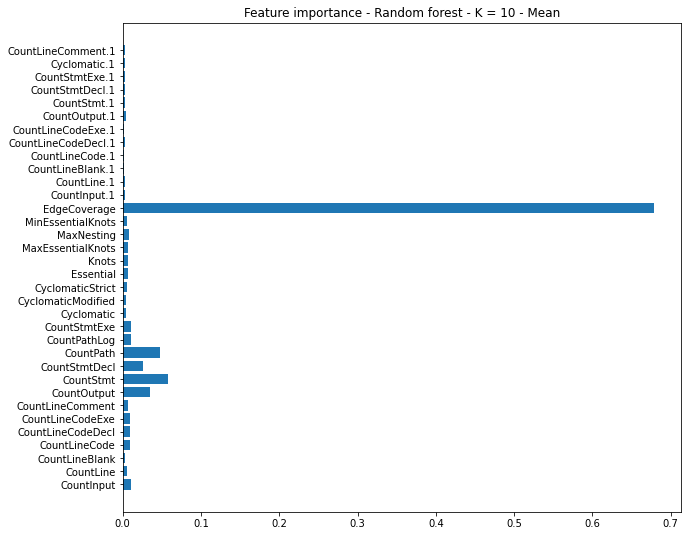



-----< COM ESCALONAMENTO >-----
EdgeCoverage           0.679364
CountStmt              0.057796
CountPath              0.047268
CountOutput            0.035336
CountStmtDecl          0.026924
CountInput             0.010646
CountPathLog           0.010259
CountLineCodeExe       0.010256
CountStmtExe           0.009861
CountLineCode          0.009675
CountLineCodeDecl      0.009304
MaxNesting             0.007752
CountLineComment       0.007193
Essential              0.006909
Knots                  0.006365
MaxEssentialKnots      0.005803
CyclomaticStrict       0.005676
MinEssentialKnots      0.005641
CountLine              0.005418
CountOutput.1          0.005130
Cyclomatic             0.003615
CyclomaticModified     0.003583
CountLineComment.1     0.003170
CountLineBlank         0.003075
CountInput.1           0.002792
CountStmtExe.1         0.002787
CountLineCodeDecl.1    0.002708
CountLine.1            0.002673
CountStmtDecl.1        0.002544
Cyclomatic.1           0.002488
CountS

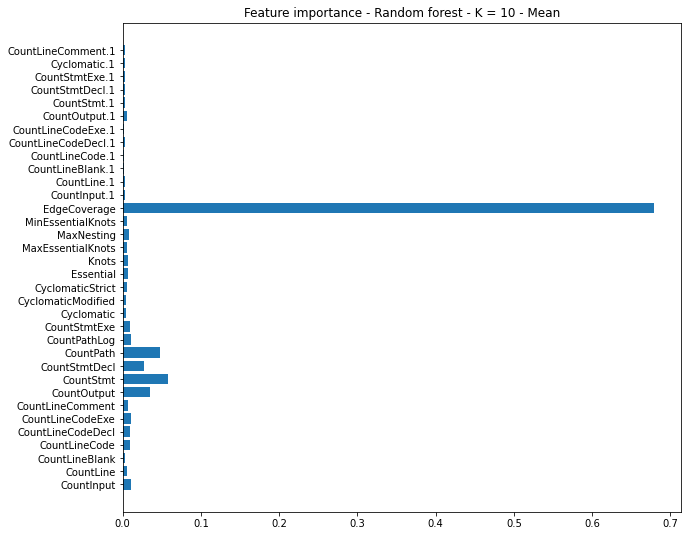

In [756]:
feature_importance(RandomForestRegressor())

In [757]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'CountPath',
    'CountStmt'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.05827969680341332
Mean Sqr Error:  0.013323444859624172
Mean Sqr Log Error:  0.006003363051728558
Mean Median Error:  0.0227900757575758
R2 Score:  0.8037210512617677
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.05868390567941814
Mean Sqr Error:  0.013568836274921713
Mean Sqr Log Error:  0.006174256909390877
Mean Median Error:  0.02306642268739558
R2 Score:  0.8007254843253997


In [758]:
evaluate([
    'CountOutput',
    'EdgeCoverage',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.0677436599246553
Mean Sqr Error:  0.016299180664770468
Mean Sqr Log Error:  0.007976002401082745
Mean Median Error:  0.023727863636363613
R2 Score:  0.7578025466786095
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.06809430444861603
Mean Sqr Error:  0.01669181324369354
Mean Sqr Log Error:  0.008173913825314906
Mean Median Error:  0.02298731060606055
R2 Score:  0.7520443925914599


In [759]:
evaluate([
    'CountOutput',
    'CountPath',
    'CountStmt'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.19249680083027218
Mean Sqr Error:  0.058783255137194575
Mean Sqr Log Error:  0.025316315960760807
Mean Median Error:  0.17737966791816187
R2 Score:  0.1061775746994503
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.19355319358972245
Mean Sqr Error:  0.05912302472965423
Mean Sqr Log Error:  0.02555584883343386
Mean Median Error:  0.1800035709258872
R2 Score:  0.10216320953906727


In [760]:
evaluate([
    'CountOutput',
    'Knots',
    'CountStmtDecl',
    'CountLineCodeDecl'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.2108318690617496
Mean Sqr Error:  0.0705505696957933
Mean Sqr Log Error:  0.030466214726826337
Mean Median Error:  0.19311159462931649
R2 Score:  0.07598143089416286
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.21002193094074056
Mean Sqr Error:  0.0703536289871339
Mean Sqr Log Error:  0.030349380733844175
Mean Median Error:  0.19404228831474626
R2 Score:  0.07274199200440136


### Sem EC

-----< SEM ESCALONAMENTO >-----


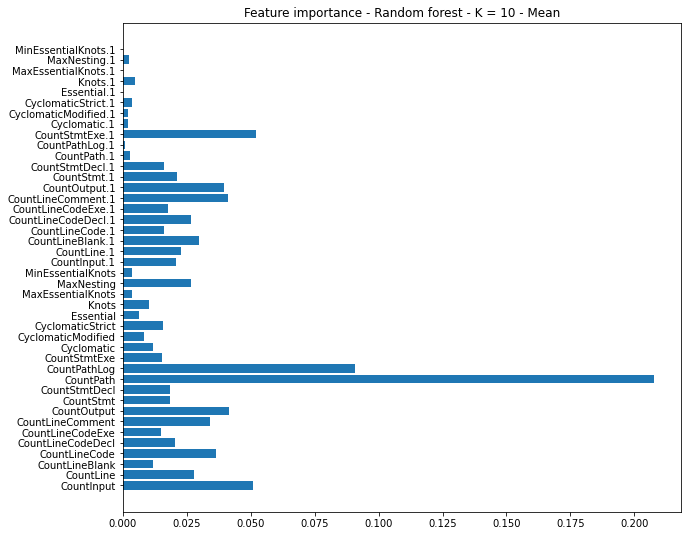



-----< COM ESCALONAMENTO >-----
CountPath               0.207356
CountPathLog            0.090972
CountStmtExe.1          0.051020
CountInput              0.050764
CountOutput             0.042605
CountLineComment.1      0.041472
CountOutput.1           0.040366
CountLineCode           0.034371
CountLineComment        0.034130
CountLineBlank.1        0.029915
MaxNesting              0.028144
CountLine               0.028131
CountLineCodeDecl.1     0.026888
CountLine.1             0.023216
CountStmt.1             0.021163
CountInput.1            0.020969
CountLineCodeDecl       0.020344
CountStmtDecl           0.019051
CountLineCodeExe.1      0.017944
CountLineCode.1         0.016392
CyclomaticStrict        0.016067
CountStmt               0.016048
CountStmtDecl.1         0.016016
CountStmtExe            0.015950
CountLineCodeExe        0.015335
Cyclomatic              0.012995
CountLineBlank          0.011656
Knots                   0.010193
CyclomaticModified      0.007320
Essential

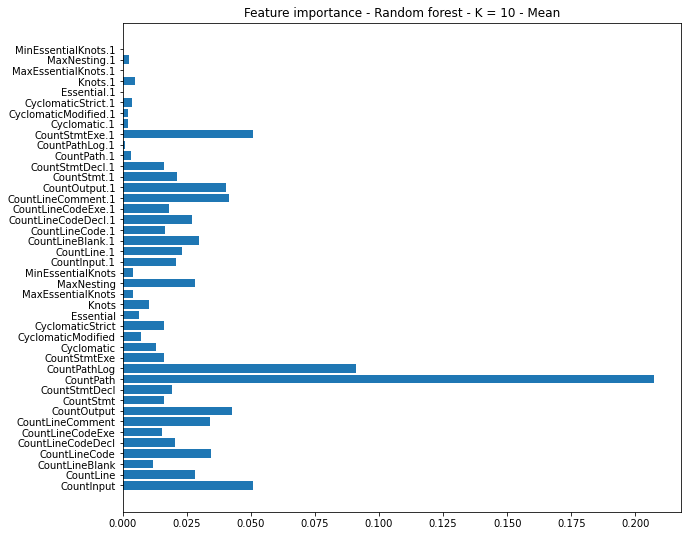

In [795]:
feature_importance(RandomForestRegressor(), prev=[
    # Método testado
    'CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1',
    'CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountStmt.1',
    'CountStmtDecl.1','CountPath.1','CountPathLog.1','CountStmtExe.1',
    'Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1',
    'Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1',
])

In [761]:
evaluate([
    'CountStmtExe.1',
    'MaxNesting',
    'CountPath',
    'CountOutput.1',
    'CountLineCodeExe.1'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.17262439116884548
Mean Sqr Error:  0.053698786932084956
Mean Sqr Log Error:  0.022483618394277885
Mean Median Error:  0.13219134946770406
R2 Score:  0.18199804857201876
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.17243553356578575
Mean Sqr Error:  0.05371980836511652
Mean Sqr Log Error:  0.02246372522295448
Mean Median Error:  0.13472206797848615
R2 Score:  0.1811442007327109


In [762]:
evaluate([
    # Método testado
    'CountInput','CountLine','CountLineCode','CountLineCodeDecl',
    'CountLineCodeExe','CountLineComment','CountOutput','CountStmt',
    'CountStmtDecl','CountPath','CountPathLog','CountStmtExe',
    'Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential',
    'Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots',
    
    # Método de teste
    'CountInput.1','CountLine.1','CountLineBlank.1',
    'CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1',
    'CountOutput.1','CountStmt.1', 'CountStmtDecl.1',
    'CountStmtExe.1','Cyclomatic.1'
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.1519914570334232
Mean Sqr Error:  0.0416389415577276
Mean Sqr Log Error:  0.017867024600795242
Mean Median Error:  0.11998007662337673
R2 Score:  0.3658938211637865
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.15122148205067087
Mean Sqr Error:  0.041516979476147846
Mean Sqr Log Error:  0.01769889194332787
Mean Median Error:  0.11989471818181818
R2 Score:  0.3666543602750542


In [763]:
evaluate([
    'CountStmtExe.1',
    'MaxNesting',
    'CountPath',
    'CountOutput.1',
    'CountLineCodeExe.1',
    'Cyclomatic',
    'CountInput',
    'CountOutput',
], RandomForestRegressor(), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.15622858237684095
Mean Sqr Error:  0.044585032538557036
Mean Sqr Log Error:  0.01886008978957762
Mean Median Error:  0.11791682330447335
R2 Score:  0.3189337133363324
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.15491130658211913
Mean Sqr Error:  0.04421546956522686
Mean Sqr Log Error:  0.01865028507172288
Mean Median Error:  0.11660591233766236
R2 Score:  0.3242063839081672


In [855]:
evaluate([
    #'CountPath',
    'CountPathLog',
    'CountStmtExe.1',
    'CountInput',
    'CountOutput',
    'CountLineComment.1',
    'CountOutput.1',
    'CountLineCode',
    'CountLineComment',
    'MaxNesting',
    'CountLineCodeDecl.1',
    'CountInput.1',
    'CountStmtDecl',
    'CountLineCodeExe.1',
    'Cyclomatic',
], RandomForestRegressor(random_state=0), dataset)

-----< SEM ESCALONAMENTO >-----
Mean Abs Error:  0.14748725394870424
Mean Sqr Error:  0.04044398641631203
Mean Sqr Log Error:  0.017081250693310457
Mean Median Error:  0.11050634090909099
R2 Score:  0.3823826260617588
-----< COM ESCALONAMENTO >-----
Mean Abs Error:  0.14754871123529797
Mean Sqr Error:  0.040423943543768215
Mean Sqr Log Error:  0.01707823681552319
Mean Median Error:  0.11075485606060603
R2 Score:  0.38297638731141587
